In [3]:

from copy import deepcopy
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta, datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas import to_datetime
from prophet import Prophet
import warnings

In [4]:
xgb.__version__

'1.5.2'

In [5]:
def get_conf(conf_path):
    """Reads configuration file"""
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [6]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if isinstance(actual, (np.ndarray, np.generic)):
        if len(actual.shape)!=2:
            actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = round(sum(diff/avg)/len(forecast) * 100, 2)

    print('SMAPE Error Score: ' + str(smape_score) + ' %')
    return smape_score

In [7]:
# Subset the entire dataset based on each store-item combination

def item_df_subset(df_1, item):
    df_2 = df_1[df_1['item'] == item]
    data = df_2.drop(columns=['store', 'item'], axis = 1)
    #data = data.groupby(['date']).agg({'sales' : 'sum'})
    train_len = int(0.9*len(data))

    train_data = data[:train_len]
    test_data = data[train_len:]

    return train_data, test_data

In [8]:
# Holt - Winters Smoothing Model

def define_hw_model(train_data, test_data, store, item):

    forecast_dates = 90

    train_data = train_data.groupby(['date']).agg({'sales' : 'sum'})
    test_data = test_data.groupby(['date']).agg({'sales' : 'sum'})

    hw_model = ExponentialSmoothing(train_data['sales'],trend='add',seasonal='add',seasonal_periods=365).fit()

    test_predictions = hw_model.forecast(steps = len(test_data))

    forecast_predictions = hw_model.forecast(steps = len(test_data) + forecast_dates)
    forecast_predictions = forecast_predictions[-forecast_dates:]

    start_date = datetime.strptime('2018-01-01', "%Y-%m-%d")
    end_date = datetime.strptime('2018-04-01', "%Y-%m-%d")

    dates_list = pd.Series(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))
    forecast_dates = pd.DataFrame(data = dates_list, columns=['Date'])

    forecast_sales = pd.DataFrame(data = forecast_predictions, columns=['sales']).reset_index()

    smape_in_loop = pd.Series(SMAPE(test_predictions, test_data['sales']))

    #smape_in_loop = pd.Series(calculate_smape)

    #smape_item_list.append(smape_in_loop)

    forecast_sales['store'] = store

    #print('forecast_sales head\n', forecast_sales.head())

    forecast_sales['item'] = item

    forecast_df = pd.concat([forecast_dates, forecast_sales], axis = 1)

    forecast_df.drop('index', axis =1, inplace=True)

    forecast_df['sales'] = forecast_df['sales'].astype('int')

    forecast_df = forecast_df[['Date', 'store', 'item', 'sales']]

    return forecast_df, smape_in_loop

In [9]:
## Holt Winters Model

def run_hw_model(df, store_list, item_list):

    store_forecast_list = []
    smape_store_list = []

    for store in store_list:

        df_1 = df[df['store'] == store]

        #print('store : ', store)

        item_forecast_list = []
        smape_item_list = []

        for item in item_list:

            train_data, test_data = item_df_subset(df_1, item)

            forecast_df, smape_in_loop = define_hw_model(train_data, test_data, store, item)

            item_forecast_list.append(forecast_df)
            smape_item_list.append(smape_in_loop)

        item_forecast_df = pd.concat(item_forecast_list)

        store_forecast_list.append(item_forecast_df)

        item_concat_smape = pd.concat(smape_item_list)
        smape_store_list.append(item_concat_smape)

    store_item_forecast_df = pd.concat(store_forecast_list)

    store_concat_smape = pd.concat(smape_store_list)
    avg_smape_hw = np.mean(store_concat_smape).round(2)

    return store_item_forecast_df, avg_smape_hw

In [10]:
def define_prophet_model(df_train, df_test, store, item):
    df_train.reset_index(inplace=True)
    df_train.rename(columns={'date' : 'ds', 'sales' : 'y'}, inplace = True)
    df_train = df_train.reset_index(drop=True)

    df_test.reset_index(inplace=True)
    df_test.rename(columns={'date' : 'ds', 'sales' : 'y'}, inplace = True)
    df_test = df_test.reset_index(drop=True)

    model = Prophet(daily_seasonality=True, interval_width=0.95)
    model = model.fit(df_train)

    future = pd.DataFrame(df_test['ds'])
    future.columns = ['ds']
    future['ds'] = to_datetime(future['ds'])

    test_predictions = model.predict(future)

    smape_in_loop = pd.Series(SMAPE((test_predictions['yhat']), (df_test['y'])))

    #item_smape_series = pd.Series(smape_item_list)

    start_date = datetime.strptime('2018-01-01', "%Y-%m-%d")
    end_date = datetime.strptime('2018-04-01', "%Y-%m-%d")
    dates_list = pd.Series(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))
    forecast_dates = pd.DataFrame(data = dates_list, columns=['ds'])

    forecast_3months = model.predict(forecast_dates)
    forecast_3months['yhat'] = (forecast_3months['yhat'].astype('int'))

    forecast_sales = forecast_3months[['ds', 'yhat']]
    forecast_sales.rename(columns = {'ds':'Date', 'yhat':'sales'}, inplace = True)
    forecast_sales['store'] = store
    forecast_sales['item'] = item

    forecast_sales = forecast_sales[['Date', 'store', 'item', 'sales']]

    return forecast_sales, smape_in_loop

In [11]:
def run_prophet_model(df, store_list, item_list):

    store_forecast_list = []
    smape_store_list = []

    for store in store_list:

        df_1 = df[df['store'] == store]
        #print('df_1 subset')
        print('\n*****Running for store - %d**********'% store)

        item_forecast_list = []
        smape_item_list = []

        for item in item_list:

            df_train, df_test = item_df_subset(df_1, item)

            forecast_sales, smape_in_loop = define_prophet_model(df_train, df_test, store, item)

            item_forecast_list.append(forecast_sales)
            smape_item_list.append(smape_in_loop)


        print('len of smape_item_list', len(smape_item_list))
        item_forecast_df = (pd.concat(item_forecast_list))
        store_forecast_list.append(item_forecast_df)

        item_concat_smape = pd.concat(smape_item_list)
        smape_store_list.append(item_concat_smape)


    store_item_forecast_df = pd.concat(store_forecast_list)
    print('len of smape_store_list', len(smape_store_list))
    #print(smape_store_list)
    store_concat_smape = pd.concat(smape_store_list)

    print('\n********Done*********\n')

    avg_smape_prophet = np.mean(store_concat_smape).round(2)

    return store_item_forecast_df, avg_smape_prophet

In [12]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [13]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [14]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.json'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)

    else:
        sorted_xgb_models = [x for x in os.listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))


    return xgb_model, dtest

In [15]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     # activation='relu',
                     input_shape=(x_train.shape[1], x_train.shape[2]),
                     # unroll=True
                     )
                )

        # mdl.add(Dropout(0.5))

        # mdl.add(LSTM(params['LSTM_NODES']//2,
        #              activation='relu',
        #              return_sequences=False
        #              )
        #         )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer='adam')

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            batch_size=90,
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = os.listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl


In [16]:
def lstm_model_v2(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model_lstm.add(Dropout(0.5))
        model_lstm.add(LSTM(params['LSTM_NODES']//2, activation='relu', return_sequences=False))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = os.listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=False)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [17]:
def lstm_model_v3(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=3)
        mdl = Sequential()

        mdl.add(LSTM(params['LSTM_NODES'],
                     activation='relu',
                     batch_input_shape=(params['LSTM_BATCH_SIZE'],x_train.shape[1], x_train.shape[2]),
                     stateful=True,
                     return_sequences=True
                     )
                )

        mdl.add(Dropout(0.5))

        mdl.add(LSTM(params['LSTM_NODES']//2,
                     activation='relu',
                     return_sequences=False
                     )
                )

        mdl.add(Dense(1))

        mdl.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))

        mdl.summary()

        lstm_history = mdl.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )

        mdl.save(lstm_model_dir+save_path)

    else:
        fnf = os.listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        mdl = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return mdl

In [18]:
def read_data(path, date_index_col, numeric_cols=None):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        if numeric_cols:
            for col in numeric_cols:
                df[col] = df[col].astype('int16')
        return df

In [19]:
# Prepare data by aggregating according to config
def data_preprocessing(data, expected_cols, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()

    if label_col in data.columns:
        data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
        data = data.agg({f'{label_col}':['mean']})
        data.columns = grouped_cols + [label_col]

    else:
        data = data[[c for c in expected_cols if c!=label_col]]
        data = data[grouped_cols]
        data = data.sort_values([c for c in grouped_cols if c!=label_col])
    return data


In [20]:
def xgboost_data_preprocessing(data_in,date_col):

    data = deepcopy(data_in)
    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek


    return data

In [21]:
def feature_engineering(data_in,date_col) -> pd.DataFrame:

    data = deepcopy(data_in)
    data.index = pd.DatetimeIndex(data[date_col])

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col], infer_datetime_format=True)
    data['year'] = data[date_col].dt.year.astype('float32')
    data['quarter'] = data[date_col].dt.quarter.astype('float32')
    data['month'] = data[date_col].dt.month.astype('float32')
    data['weekofyear'] = data.index.isocalendar().week.astype('float32')
    data['dayofweek'] = data[date_col].dt.dayofweek.astype('float32')
    data.drop(f'{date_col}', axis=1, inplace=True)
    data.reset_index(inplace=True)


    return data

In [22]:
def series_to_supervised(data, index, target, categories, lookback=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(lookback, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1, join='inner')
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{lookback})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t+{lag})'] == agg[cat])]

    return agg

In [23]:
def series_to_supervised_forecast(data, index, target, categories, lookback=1, lag=1):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(lookback, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data)
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{lookback})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t)'] == agg[cat])]

    # Putting 0s in (t+lag) column
    agg[f'{target}(t+{lag})'] = 0
    return agg

In [24]:
def split_train_valid(data, label, test_size, lag):

    # Label
    labels_col = f'{label}(t+{lag})'
    labels = data[labels_col]
    data = data.drop([x for x in data.columns if '+' in str(x)], axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, shuffle=False)

    return X_train, Y_train, X_valid, Y_valid

In [25]:
def split_xy(data, data_cols, label_col):
    label_pos = data_cols.index(label_col) + 1
    col_len = len(data_cols)
    act_len = col_len-1 #Removing index
    label_index = data.shape[1] - (act_len - label_pos) - 2
    labels = data[:,label_index]
    data = data[:,:data.shape[1] - act_len] #Removing target columns
    return data,labels

In [26]:
def reshape_features(X_train,X_valid, lookback, features):
    X_train_series = X_train.reshape((X_train.shape[0], lookback+1, features))
    X_valid_series = X_valid.reshape((X_valid.shape[0], lookback+1, features))
    return X_train_series, X_valid_series

In [27]:
def data_scaler(data, scaled, inverse=False, model=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+model+SCALER_FILE)

        if inverse:
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        joblib.dump(scaler, OBJECTS_DIR+model+SCALER_FILE)
        return scaled_data

In [28]:
def prepare_data_for_training(train, config):

    # Split training data categorically into training eval set
    train_set, eval_set = category_wise_split_train_eval(train, config['CATEGORIES'], eval_len=config['LSTM_PARAMS']['LSTM_EVAL_LEN'])

    # Convert training data into format fit for LSTM
    seq_train_set = series_to_supervised(train_set,
                                         index=config['INDEX_COL'],
                                         target=config['LABEL_COL'],
                                         categories=config['CATEGORIES'],
                                         lookback=config['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                         lag=config['LSTM_PARAMS']['LSTM_PREDICTION_LAG'])

    # Convert evaluation data into format fit for LSTM
    seq_eval_set = series_to_supervised(eval_set,
                                        index=config['INDEX_COL'],
                                        target=config['LABEL_COL'],
                                        categories=config['CATEGORIES'],
                                        lookback=config['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                        lag=config['LSTM_PARAMS']['LSTM_PREDICTION_LAG'])

    # Scale data for training
    train_scaled = data_scaler(seq_train_set, scaled=0, model='lstm')
    eval_scaled = data_scaler(seq_eval_set, scaled=1, model='lstm')

    # Split train eval into x & y
    x_train, y_train = split_xy(train_scaled, config['DATA_COLS'], config['LABEL_COL'])
    x_eval, y_eval = split_xy(eval_scaled, config['DATA_COLS'], config['LABEL_COL'])

    # Reshape data for training
    x_train_reshaped, x_eval_reshaped = reshape_features(x_train,
                                                         x_eval,
                                                         lookback=config['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                                         features=len(config['GROUPED_COLS']))

    # Reshape target labels
    y_train_reshaped, y_eval_reshaped = y_train.reshape((y_train.shape[0], 1)), y_eval.reshape((y_eval.shape[0], 1))

    return x_train_reshaped, y_train_reshaped, x_eval_reshaped, y_eval_reshaped, eval_scaled, seq_eval_set

In [29]:
def category_wise_split_train_eval(data, categories, eval_len):
    split_train = []
    split_test = []
    for i, frame in data.groupby(categories):
        split_train.append(frame[:-eval_len])
        split_test.append(frame[-eval_len:])

    train = pd.concat(split_train, axis=0)
    eval = pd.concat(split_test, axis=0)

    return train, eval

In [30]:
def pred_eval_lstm(model, x_eval_reshaped, eval_scaled, seq_eval_set):
    """Making predictions with eval data & get metrics"""

    # Obtain predictions on eval dataset
    pred = model.predict(x_eval_reshaped)

    # Inverse scaling predictions and calculating SMAPE
    eval_with_pred = np.concatenate((eval_scaled[:,:-1], pred), axis=1)
    eval_with_pred = data_scaler(eval_with_pred, scaled=1, inverse=True, model='lstm')
    inv_pred = eval_with_pred[:,-1].reshape(-1,1)
    inv_eval_y = seq_eval_set.iloc[:,-1].values.reshape(-1,1)

    # SMAPE
    lstm_smape = SMAPE(inv_pred, inv_eval_y)

    # LSTM Evaluation - MSE
    lstm_mse = model.evaluate(x_eval_reshaped,eval_scaled[:,-1].reshape(-1,1))

    plot_pred_vs_act(inv_eval_y[-1000:],inv_pred[-1000:],'LSTM')

    return lstm_smape, lstm_mse

In [31]:
def get_last_n_days_data(data, gp_cols, lookback,lag):
    sections = []
    index_name = data.index.name

    for i, frame in data.groupby(data.index):
        sections.append(frame)

    sections = sections[-(lookback+lag):]

    sections_df = pd.concat(sections, axis=0)
    sections_df = sections_df.reset_index().sort_values(gp_cols).set_index(index_name)

    return sections_df

In [32]:
def prepare_data_for_forecast_lstm(data, config):

    # Get data from dataset to be converted into LSTM sequence format
    sec_df = get_last_n_days_data(data,
                                  config['GROUPED_COLS'],
                                  config['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                  config['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                  )

    # Convert above data to LSTM sequence format
    forecast_set = series_to_supervised_forecast(sec_df,
                                                 index=config['INDEX_COL'],
                                                 target=config['LABEL_COL'],
                                                 categories=config['CATEGORIES'],
                                                 lookback=config['LSTM_PARAMS']['LSTM_LOOKBACK'],
                                                 lag=config['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                                 )
    # Scale prediction data
    forecast_set_scaled = data_scaler(forecast_set, scaled=1, model='lstm')

    # Split prediction data into x & y
    x_forecast, y_forecast= split_xy(forecast_set_scaled, conf['DATA_COLS'], conf['LABEL_COL'])

    # Reshape data for predictions

    x_forecast_series = x_forecast.reshape((x_forecast.shape[0],
                                            conf['LSTM_PARAMS']['LSTM_LOOKBACK']+1,
                                            len(conf['GROUPED_COLS']))
                                           )

    return x_forecast_series, forecast_set_scaled

In [33]:
def forecast_lstm(model, test, x_forecast_series, forecast_scaled, config):

    # Get forecast
    day_n_forecast_scaled = model.predict(x_forecast_series)

    # Add forecast to forecast dataset
    forecast_with_pred = np.concatenate((forecast_scaled[:,:-1], day_n_forecast_scaled), axis=1)

    # Inverse scale forecast data
    forecast_with_pred = data_scaler(forecast_with_pred, scaled=1, inverse=True, model='lstm')

    # Obtain inverse scaled forecasted target values
    inv_forecast = forecast_with_pred[:,-1].reshape(-1,1)

    # Generating output of test data with predicted target values
    result_lstm = deepcopy(test)
    result_lstm[f'{config["LABEL_COL"]}'] = inv_forecast

    return result_lstm

In [34]:
def prepare_data_for_training_xgb(train, config):

    preprocessed_data = data_preprocessing(train,
                                           config['DATA_COLS'],
                                           config['GROUPED_COLS'],
                                           config['LABEL_COL'],
                                           config['INDEX_COL'])

    xgb_data = feature_engineering(preprocessed_data, config['INDEX_COL'])

    # Split train eval data
    xgb_train_x, xgb_eval_x, xgb_train_y, xgb_eval_y = train_test_split(
        xgb_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
        xgb_data[conf["LABEL_COL"]],
        test_size=0.2)

    return xgb_train_x, xgb_train_y, xgb_eval_x, xgb_eval_y

In [35]:
def pred_eval_xgb(model, xgb_eval_data, xgb_eval_y ):

    # Get predictions from XGBoost model
    xgb_predictions = pd.Series(model.predict(xgb_eval_data))

    # Transform predictions and actual data for SMAPE
    xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
    xgb_test_y_reshaped = np.array(xgb_eval_y).reshape(len(xgb_eval_y),1)

    # Get SMAPE for XGBoost
    xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

    # MSE Computation
    xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

    plot_pred_vs_act(xgb_eval_y.to_numpy()[-90:],xgb_predictions_reshaped[-90:],'XGB')

    return xgb_smape, xgb_mse

In [36]:
def prepare_data_for_forecast_xgb(test, config):

    # Prepare test data for forecast
    preprocessed_test_data = data_preprocessing(test,
                                                config['DATA_COLS'],
                                                config['GROUPED_COLS'],
                                                config['LABEL_COL'],
                                                config['INDEX_COL'])

    # Add features to prediction dataset
    xgb_test_data = feature_engineering(preprocessed_test_data, config['INDEX_COL'])

    # Convert prediction dataset into DMatrix for optimized operations
    xgb_test_dmat = xgb.DMatrix(xgb_test_data.drop(f'{config["INDEX_COL"]}', axis=1))

    return xgb_test_data, xgb_test_dmat

In [37]:
def forecast_xgb(xgb_model, xgb_test_dmat, test, config):
    # Get predictions from XGBoost model
    xgb_forecast = pd.Series(xgb_model.predict(xgb_test_dmat))

    result_xgb = deepcopy(test)

    result_xgb[f'{config["LABEL_COL"]}'] = xgb_forecast.to_numpy()

    return result_xgb

In [38]:
def plot_xgb_vs_lstm(result_xgb, result_lstm, lag, label, store, item):
    plt.plot(result_xgb[label][lag*(item-1 + (store-1)*50) : lag*(item + (store - 1)*50)], label='XGB')
    plt.plot(result_lstm[label][lag*(item-1 + (store-1)*50) : lag*(item + (store - 1)*50)], label='LSTM')
    plt.legend()
    plt.title(f'Comparing XGB vs LSTM for out of sample predictions for store {store} item {item}')

In [39]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')
conf = get_conf(CONFIGS_PATH)

SCALER_FILE = 'lag1_scaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]
warnings.filterwarnings("ignore")

In [40]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0, conf['NUMERIC_COLS'])
test = read_data(TEST_PATH, 1)

# Running for all the stores and items
store_list = train.store.unique()
item_list = train.item.unique()

# Running for 2 stores and 3 items
store_list = [1, 2]
item_list = [1, 2 , 3]

In [41]:
# Transform training raw data into format fit for LSTM
x_train_reshaped, y_train_reshaped, x_eval_reshaped, y_eval_reshaped, eval_scaled, seq_eval_set = prepare_data_for_training(train, conf)

In [42]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        x_train_reshaped,
                        y_train_reshaped,
                        x_eval_reshaped,
                        y_eval_reshaped,
                        training_req=0)

2829/2829 [==============================] - 13s 3ms/step
SMAPE Error Score: 13.85 %
2829/2829 [==============================] - 11s 4ms/step - loss: 0.1188


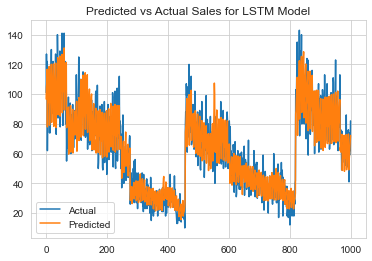

In [43]:
# Making predictions with eval data & get metrics
lstm_smape, lstm_mse = pred_eval_lstm(model_lstm,
                                      x_eval_reshaped,
                                      eval_scaled,
                                      seq_eval_set)

In [44]:
# PREDICTING NEXT 90 DAYS

In [45]:
# Prepare forecast data
x_forecast_series, forecast_scaled = prepare_data_for_forecast_lstm(train, conf)

In [46]:
# Get predictions for test dataset
result_lstm = forecast_lstm(model_lstm,
                            test,
                            x_forecast_series,
                            forecast_scaled,
                            conf)

1407/1407 [==============================] - 4s 3ms/step


<h1> XGBoost </h1>

In [47]:
# Obtain train test x & y for XGBoost
xgb_train_x, xgb_train_y, xgb_eval_x, xgb_eval_y = prepare_data_for_training_xgb(train, conf)

In [48]:
# Train XGBoost model
xgb_model, xgb_eval_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_eval_x,
                                  xgb_eval_y,
                                  training_req=1
                                  )

[00:06:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




SMAPE Error Score: 15.21 %


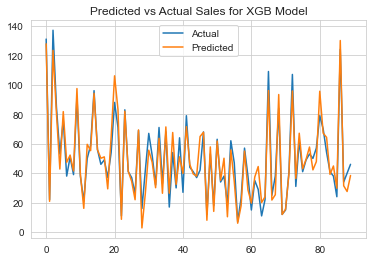

In [154]:
# Predict and Evaluate XGBoost on eval dataset
xgb_smape, xgb_mse = pred_eval_xgb(xgb_model,xgb_eval_data,xgb_eval_y)

In [155]:
# PREDICTING NEXT 90 DAYS

In [156]:
# Prepare prediction data for forecasting
xgb_test_data, xgb_test_dmat = prepare_data_for_forecast_xgb(test, conf)

In [157]:
# Get forecast from XGBoost model
result_xgb = forecast_xgb(xgb_model, xgb_test_dmat, test, conf)

<h1> Prophet & Holt-Winters </h1>

<h4> Holt Winters </h4>

In [195]:
store_item_forecast_hw, avg_smape_hw = run_hw_model(train, store_list, item_list)

SMAPE Error Score: 23.2 %
SMAPE Error Score: 16.56 %
SMAPE Error Score: 20.06 %
SMAPE Error Score: 20.3 %
SMAPE Error Score: 16.74 %
SMAPE Error Score: 16.55 %


<h4> Prophet </h4>

In [210]:
store_item_forecast_prophet, avg_smape_prophet = run_prophet_model(train, store_list, item_list)


12:54:33 - cmdstanpy - INFO - Chain [1] start processing



*****Running for store - 1**********


12:54:33 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 17.73 %


12:54:35 - cmdstanpy - INFO - Chain [1] start processing
12:54:35 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 10.32 %


12:54:37 - cmdstanpy - INFO - Chain [1] start processing
12:54:37 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 14.35 %
len of smape_item_list 3

*****Running for store - 2**********


12:54:39 - cmdstanpy - INFO - Chain [1] start processing
12:54:39 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 15.21 %


12:54:41 - cmdstanpy - INFO - Chain [1] start processing
12:54:41 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 9.86 %


12:54:42 - cmdstanpy - INFO - Chain [1] start processing
12:54:42 - cmdstanpy - INFO - Chain [1] done processing


SMAPE Error Score: 11.3 %
len of smape_item_list 3
len of smape_store_list 2

********Done*********



<h1> Comparing the models' metrics </h1>

In [220]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')
print(f'Holt Winters SMAPE- {avg_smape_hw}%')
print(f'Prophet SMAPE- {avg_smape_prophet}%')


print('---------------------------')
print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.21%
LSTM SMAPE- 13.85%
Holt Winters SMAPE- 18.901666666666664%
Prophet SMAPE- 13.128333333333332%
---------------------------
XGB MSE- 67.95
LSTM MSE- 0.12


<h1> Plotting predictions for next 90 days for LSTM vs XGB </h1>

Text(0.5, 1.0, 'Comparing XGB vs LSTM for out of sample predictions for store 1 item 1')

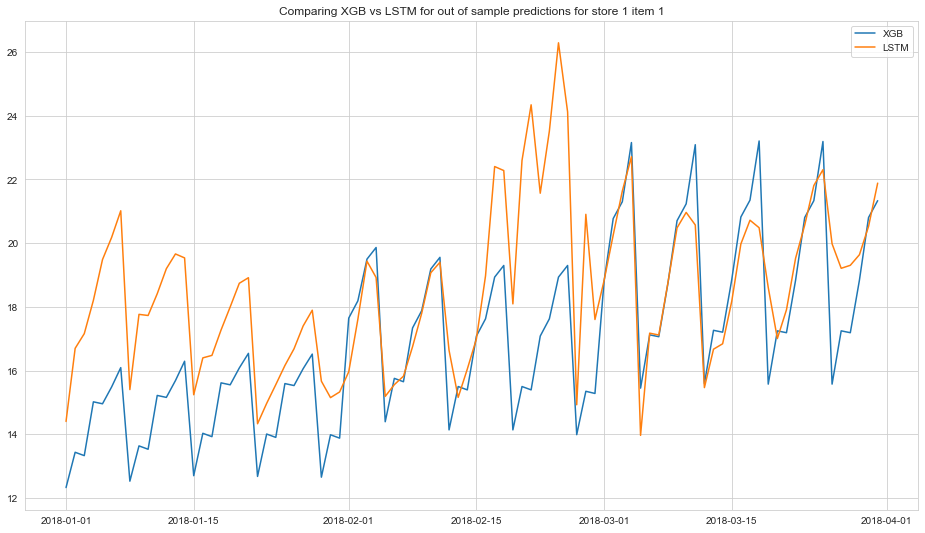

In [212]:
plt.plot(result_xgb[f'{conf["LABEL_COL"]}'][:90], label='XGB')
plt.plot(result_lstm[f'{conf["LABEL_COL"]}'][:90], label='LSTM')
plt.legend()
plt.title('Comparing XGB vs LSTM for out of sample predictions for store 1 item 1')

Text(0.5, 1.0, 'Comparing XGB vs LSTM for out of sample predictions for store 1 item 2')

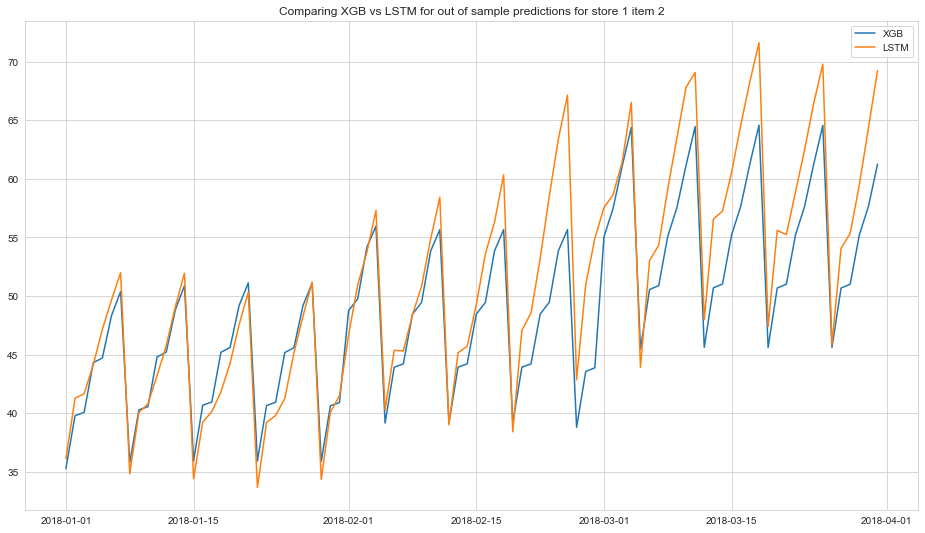

In [213]:
plt.plot(result_xgb[f'{conf["LABEL_COL"]}'][90:180], label='XGB')
plt.plot(result_lstm[f'{conf["LABEL_COL"]}'][90:180], label='LSTM')
plt.legend()
plt.title('Comparing XGB vs LSTM for out of sample predictions for store 1 item 2')

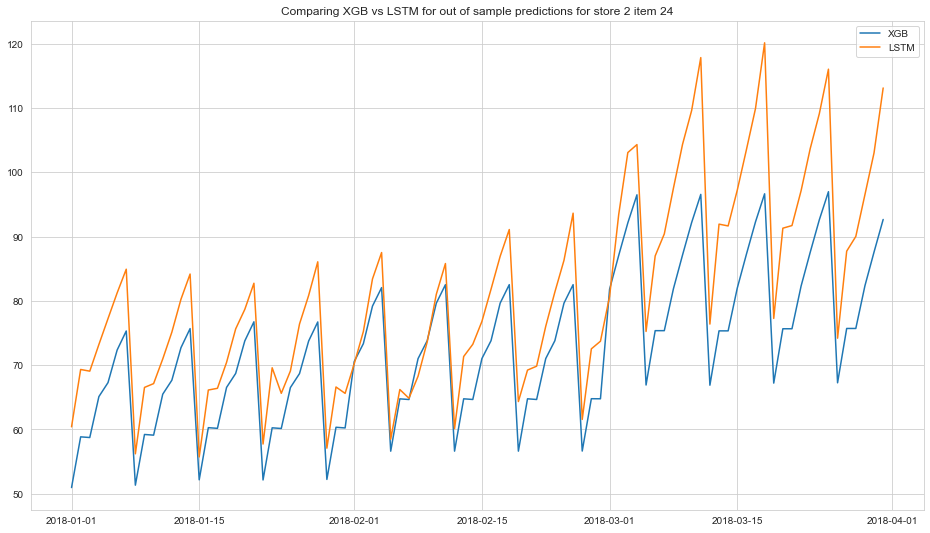

In [214]:
plot_xgb_vs_lstm(result_xgb,
                 result_lstm,
                 conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG'],
                 conf['LABEL_COL'],
                 store=2,
                 item=24)

In [215]:
result_lstm

,id,store,item,sales
date,,,,
2018-01-01,0,1,1,14.402564
2018-01-02,1,1,1,16.697012
2018-01-03,2,1,1,17.158035
2018-01-04,3,1,1,18.204073
2018-01-05,4,1,1,19.483436
...,...,...,...,...
2018-03-27,44995,10,50,78.585349
2018-03-28,44996,10,50,84.280728
2018-03-29,44997,10,50,93.251667


In [216]:
store_item_forecast_prophet

,Date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,15
2,2018-01-03,1,1,16
3,2018-01-04,1,1,16
4,2018-01-05,1,1,18
...,...,...,...,...
85,2018-03-27,2,3,49
86,2018-03-28,2,3,50
87,2018-03-29,2,3,53
88,2018-03-30,2,3,57


In [217]:
store_item_forecast_hw

,Date,store,item,sales
0,2018-01-01,1,1,19
1,2018-01-02,1,1,17
2,2018-01-03,1,1,17
3,2018-01-04,1,1,17
4,2018-01-05,1,1,17
...,...,...,...,...
85,2018-03-27,2,3,53
86,2018-03-28,2,3,45
87,2018-03-29,2,3,49
88,2018-03-30,2,3,54
